# Knowledge Distillation with PyTorch on CIFAR-10

Knowledge distillation is a model compression technique where a small model (student) is trained to mimic a larger pre-trained model (teacher). This approach allows us to transfer the knowledge embedded in a large, computationally expensive model to a smaller, more efficient one.

In this notebook, we'll implement three approaches:
1. **Standard Training**: Train a student model directly on the data
2. **Logits-based Distillation**: Train a student model to mimic the soft outputs (logits) of a teacher model
3. **Feature-based Distillation**: Train a student model to match both the outputs and intermediate feature representations of a teacher model

References:
- [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531) (Hinton et al., 2015)
- [PyTorch Knowledge Distillation Tutorial](https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html)

In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [2]:
# Import our distillation utilities
from distil_pytorch import (
    create_teacher_model, 
    create_student_model, 
    DistillationLoss, 
    FeatureDistillationLoss,
    train_teacher,
    train_student_with_teacher, 
    train_student_with_teacher_model,
    train_student_with_feature_distillation,
    train_model_directly,
    count_parameters,
    evaluate_model,
    load_cifar10,
    visualize_samples
)

In [3]:
# Configuration
BATCH_SIZE = 128
TEACHER_EPOCHS = 25
STUDENT_EPOCHS = 15
FEATURE_EPOCHS = 10
LEARNING_RATE = 0.001
ALPHA = 0.5     # Weight for hard labels (ground truth)
BETA = 0.4      # Weight for feature matching
TEMPERATURE = 3.0  # Temperature parameter for distillation

Data loaders created with batch size 128


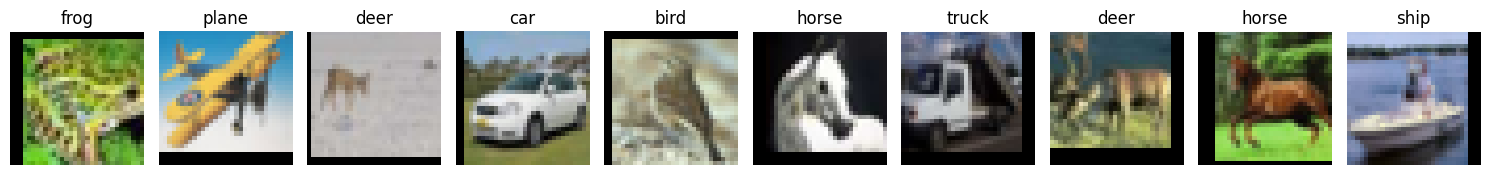

In [4]:
# Load CIFAR-10 dataset
train_loader, test_loader, classes = load_cifar10(batch_size=BATCH_SIZE)
print(f"Data loaders created with batch size {BATCH_SIZE}")

# Visualize some samples
visualize_samples(train_loader, classes, num_samples=10)

## Teacher Model Training

First, we'll create and train a teacher model with higher capacity. Our teacher CNN has:
- Scale factor of 32 (more filters)
- ~2.1 million parameters
- Higher representational capacity

In [5]:
# Create the teacher model
teacher_model = create_teacher_model().to(DEVICE)
teacher_params = count_parameters(teacher_model)
print(f"Teacher model created with {teacher_params:,} parameters")

# Train teacher model
print("\nTraining teacher model...")
teacher_model, teacher_history = train_teacher(
    teacher_model, train_loader, test_loader, 
    epochs=TEACHER_EPOCHS, 
    device=DEVICE,
    lr=LEARNING_RATE
)

# Evaluate teacher model
teacher_acc = evaluate_model(teacher_model, test_loader, DEVICE)
print(f"\nTeacher model accuracy: {teacher_acc:.4f}")

Teacher model created with 2,168,362 parameters

Training teacher model...
Epoch 1/25 - Train Loss: 1.6252 - Train Acc: 0.4089 - Val Loss: 1.2111 - Val Acc: 0.5721
Epoch 2/25 - Train Loss: 1.2884 - Train Acc: 0.5413 - Val Loss: 1.0297 - Val Acc: 0.6404
Epoch 3/25 - Train Loss: 1.1510 - Train Acc: 0.5924 - Val Loss: 0.9361 - Val Acc: 0.6746
Epoch 4/25 - Train Loss: 1.0593 - Train Acc: 0.6275 - Val Loss: 0.8591 - Val Acc: 0.7058
Epoch 5/25 - Train Loss: 1.0007 - Train Acc: 0.6496 - Val Loss: 0.8017 - Val Acc: 0.7240
Epoch 6/25 - Train Loss: 0.9634 - Train Acc: 0.6648 - Val Loss: 0.8099 - Val Acc: 0.7145
Epoch 7/25 - Train Loss: 0.9239 - Train Acc: 0.6767 - Val Loss: 0.7423 - Val Acc: 0.7473
Epoch 8/25 - Train Loss: 0.8842 - Train Acc: 0.6944 - Val Loss: 0.7109 - Val Acc: 0.7554
Epoch 9/25 - Train Loss: 0.8523 - Train Acc: 0.7021 - Val Loss: 0.6899 - Val Acc: 0.7651
Epoch 10/25 - Train Loss: 0.8248 - Train Acc: 0.7113 - Val Loss: 0.6762 - Val Acc: 0.7648
Epoch 11/25 - Train Loss: 0.7966 -

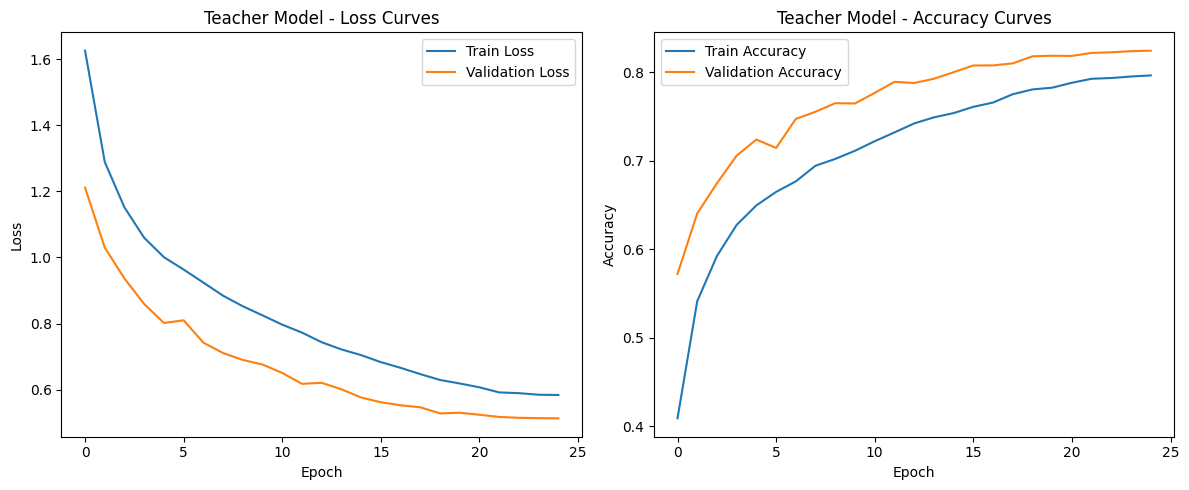

In [6]:
# Plot teacher training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(teacher_history['train_loss'], label='Train Loss')
plt.plot(teacher_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Teacher Model - Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(teacher_history['train_acc'], label='Train Accuracy')
plt.plot(teacher_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Teacher Model - Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

## Student Model

Now we'll create a student model with reduced capacity. Our student CNN has:
- Scale factor of 16 (fewer filters)
- ~1 million parameters
- Lower computation and memory requirements

We'll train this student model in three ways:
1. Directly with data (standard cross-entropy)
2. With logits distillation (mimicking teacher's soft outputs)
3. With feature distillation (mimicking both outputs and internal representations)

As explained in the [PyTorch Knowledge Distillation Tutorial](https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html):

> Knowledge distillation works by incorporating an additional loss into the traditional cross entropy loss, which is based on the softmax output of the teacher network. The assumption is that the output activations of a properly trained teacher network carry additional information that can be leveraged by a student network during training.

In [7]:
# Create student model for direct training
student_model_direct = create_student_model().to(DEVICE)
student_params = count_parameters(student_model_direct)
print(f"Student model created with {student_params:,} parameters")

# Train student model directly (standard training)
print("\nTraining student model directly...")
student_model_direct, direct_history = train_model_directly(
    student_model_direct, train_loader, test_loader, 
    epochs=STUDENT_EPOCHS, 
    device=DEVICE,
    lr=LEARNING_RATE
)

Student model created with 1,070,874 parameters

Training student model directly...
Epoch 1/15 - Train Loss: 1.6795 - Train Acc: 0.3900 - Val Loss: 1.3220 - Val Acc: 0.5267
Epoch 2/15 - Train Loss: 1.4022 - Train Acc: 0.4992 - Val Loss: 1.1796 - Val Acc: 0.5827
Epoch 3/15 - Train Loss: 1.2768 - Train Acc: 0.5485 - Val Loss: 1.0390 - Val Acc: 0.6392
Epoch 4/15 - Train Loss: 1.1857 - Train Acc: 0.5829 - Val Loss: 0.9674 - Val Acc: 0.6695
Epoch 5/15 - Train Loss: 1.1234 - Train Acc: 0.6033 - Val Loss: 0.9017 - Val Acc: 0.6857
Epoch 6/15 - Train Loss: 1.0502 - Train Acc: 0.6280 - Val Loss: 0.8534 - Val Acc: 0.7062
Epoch 7/15 - Train Loss: 1.0059 - Train Acc: 0.6465 - Val Loss: 0.8350 - Val Acc: 0.7144
Epoch 8/15 - Train Loss: 0.9656 - Train Acc: 0.6597 - Val Loss: 0.8003 - Val Acc: 0.7240
Epoch 9/15 - Train Loss: 0.9260 - Train Acc: 0.6785 - Val Loss: 0.7689 - Val Acc: 0.7361
Epoch 10/15 - Train Loss: 0.8945 - Train Acc: 0.6852 - Val Loss: 0.7644 - Val Acc: 0.7366
Epoch 11/15 - Train Loss:

## Logits-based Knowledge Distillation

In logits-based distillation, the student model learns from:
1. Hard labels (ground truth) with weight α
2. Soft labels (teacher logits) with weight (1-α)

The temperature parameter T controls how "soft" the probability distributions become:
- Higher T → softer distributions (smaller probabilities get a larger boost)
- Lower T → sharper distributions

This allows the student to learn the underlying similarity structure captured by the teacher model.

In [8]:
# Create student model for logits distillation
student_model_logits = create_student_model().to(DEVICE)

# Train student model with logits distillation
print("\nTraining student model with logits-based distillation...")
student_model_logits, logits_history = train_student_with_teacher_model(
    student_model_logits, teacher_model, 
    train_loader, test_loader,
    epochs=STUDENT_EPOCHS, 
    alpha=ALPHA, 
    temperature=TEMPERATURE, 
    device=DEVICE,
    lr=LEARNING_RATE
)


Training student model with logits-based distillation...
Generating teacher predictions...
Generated predictions for 50000 samples
Epoch 1/15 - Train Loss: 4.5861 - Train Acc: 0.3041 - Val Loss: 1.8987 - Val Acc: 0.3911
Epoch 2/15 - Train Loss: 4.5276 - Train Acc: 0.4084 - Val Loss: 1.6819 - Val Acc: 0.4997
Epoch 3/15 - Train Loss: 4.5028 - Train Acc: 0.4559 - Val Loss: 1.5969 - Val Acc: 0.5535
Epoch 4/15 - Train Loss: 4.4838 - Train Acc: 0.4883 - Val Loss: 1.6013 - Val Acc: 0.5562
Epoch 5/15 - Train Loss: 4.4667 - Train Acc: 0.5047 - Val Loss: 1.5413 - Val Acc: 0.5827
Epoch 6/15 - Train Loss: 4.4512 - Train Acc: 0.5269 - Val Loss: 1.5053 - Val Acc: 0.5985
Epoch 7/15 - Train Loss: 4.4418 - Train Acc: 0.5427 - Val Loss: 1.4842 - Val Acc: 0.6018
Epoch 8/15 - Train Loss: 4.4359 - Train Acc: 0.5523 - Val Loss: 1.4670 - Val Acc: 0.6272
Epoch 9/15 - Train Loss: 4.4233 - Train Acc: 0.5663 - Val Loss: 1.4430 - Val Acc: 0.6369
Epoch 10/15 - Train Loss: 4.4203 - Train Acc: 0.5748 - Val Loss: 1.

## Feature-based Knowledge Distillation

Feature-based distillation is a more comprehensive approach that transfers not only output knowledge but also internal representations. It works by:

1. Extracting intermediate feature maps from both the teacher and student
2. Adding an additional loss term that pushes the student's feature maps to match the teacher's
3. Combining three types of loss:
   - Hard labels (ground truth) loss - weight α
   - Feature matching loss - weight β
   - Soft targets (logits) loss - weight (1-α-β)

This approach provides richer supervision signals for the student model, potentially leading to better performance.

As noted in [PyTorch's tutorial](https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html), using feature maps "conveys information from the teacher's representation to the student by including a naive loss function, whose minimization implies that the flattened vectors that are subsequently passed to the classifiers have become more similar."

In [9]:
# Create student model for feature distillation
student_model_feature = create_student_model().to(DEVICE)

# Train student model with feature distillation
print("\nTraining student model with feature-based distillation...")
student_model_feature, feature_history = train_student_with_feature_distillation(
    student_model_feature, teacher_model, 
    train_loader, test_loader,
    epochs=FEATURE_EPOCHS, 
    alpha=ALPHA, 
    beta=BETA, 
    temperature=TEMPERATURE, 
    device=DEVICE,
    lr=LEARNING_RATE
)


Training student model with feature-based distillation...
Epoch 1/10 - Train Loss: 2.7854 - Train Acc: 0.3661 - Val Loss: 1.3761 - Val Acc: 0.5187
Epoch 2/10 - Train Loss: 2.0665 - Train Acc: 0.5083 - Val Loss: 1.1042 - Val Acc: 0.6199
Epoch 3/10 - Train Loss: 1.6023 - Train Acc: 0.5898 - Val Loss: 0.9323 - Val Acc: 0.6849
Epoch 4/10 - Train Loss: 1.2628 - Train Acc: 0.6478 - Val Loss: 0.8049 - Val Acc: 0.7247
Epoch 5/10 - Train Loss: 1.0766 - Train Acc: 0.6765 - Val Loss: 0.7426 - Val Acc: 0.7465
Epoch 6/10 - Train Loss: 0.9572 - Train Acc: 0.6985 - Val Loss: 0.7350 - Val Acc: 0.7520
Epoch 7/10 - Train Loss: 0.8858 - Train Acc: 0.7076 - Val Loss: 0.6936 - Val Acc: 0.7636
Epoch 8/10 - Train Loss: 0.8391 - Train Acc: 0.7200 - Val Loss: 0.6753 - Val Acc: 0.7698
Epoch 9/10 - Train Loss: 0.8066 - Train Acc: 0.7249 - Val Loss: 0.6623 - Val Acc: 0.7733
Epoch 10/10 - Train Loss: 0.7990 - Train Acc: 0.7267 - Val Loss: 0.6602 - Val Acc: 0.7734


In [10]:
# Evaluate all models
student_direct_acc = evaluate_model(student_model_direct, test_loader, DEVICE)
student_logits_acc = evaluate_model(student_model_logits, test_loader, DEVICE)
student_feature_acc = evaluate_model(student_model_feature, test_loader, DEVICE)

print("\nFinal Results:")
print(f"Teacher model accuracy: {teacher_acc:.4f}")
print(f"Student model with direct training accuracy: {student_direct_acc:.4f}")
print(f"Student model with logits distillation accuracy: {student_logits_acc:.4f}")
print(f"Student model with feature distillation accuracy: {student_feature_acc:.4f}")

print(f"\nComparison:")
print(f"Feature distillation vs logits distillation: {(student_feature_acc - student_logits_acc) * 100:.2f}% difference")
print(f"Feature distillation vs direct training: {(student_feature_acc - student_direct_acc) * 100:.2f}% difference")
print(f"Teacher to feature-distilled student gap: {(teacher_acc - student_feature_acc) * 100:.2f}% absolute")


Final Results:
Teacher model accuracy: 0.8244
Student model with direct training accuracy: 0.7583
Student model with logits distillation accuracy: 0.6654
Student model with feature distillation accuracy: 0.7734

Comparison:
Feature distillation vs logits distillation: 10.80% difference
Feature distillation vs direct training: 1.51% difference
Teacher to feature-distilled student gap: 5.10% absolute


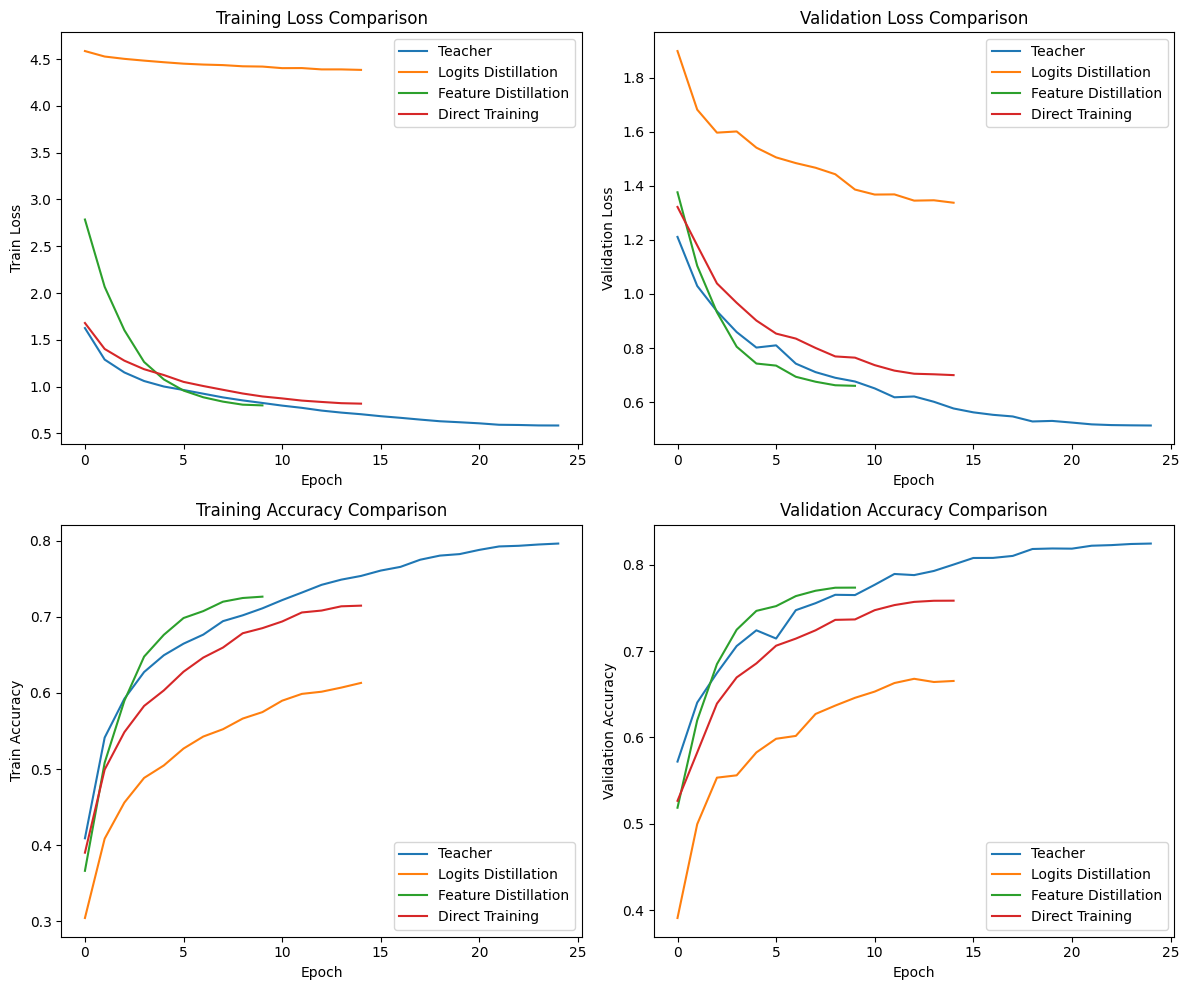

In [11]:
# Plot all student model training histories
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(teacher_history['train_loss'], label='Teacher')
plt.plot(logits_history['train_loss'], label='Logits Distillation')
plt.plot(feature_history['train_loss'], label='Feature Distillation')
plt.plot(direct_history['train_loss'], label='Direct Training')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(teacher_history['val_loss'], label='Teacher')
plt.plot(logits_history['val_loss'], label='Logits Distillation')
plt.plot(feature_history['val_loss'], label='Feature Distillation')
plt.plot(direct_history['val_loss'], label='Direct Training')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(teacher_history['train_acc'], label='Teacher')
plt.plot(logits_history['train_acc'], label='Logits Distillation')
plt.plot(feature_history['train_acc'], label='Feature Distillation')
plt.plot(direct_history['train_acc'], label='Direct Training')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(teacher_history['val_acc'], label='Teacher')
plt.plot(logits_history['val_acc'], label='Logits Distillation')
plt.plot(feature_history['val_acc'], label='Feature Distillation')
plt.plot(direct_history['val_acc'], label='Direct Training')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.savefig('distillation_comparison.png')
plt.show()

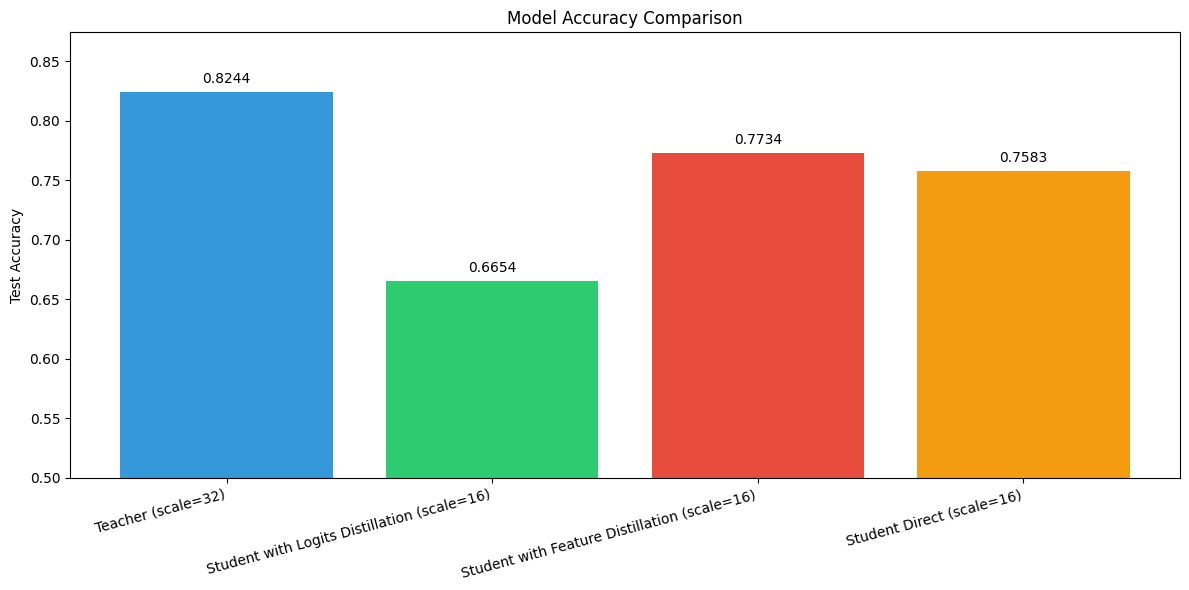

In [12]:
data = {
    'Model': ['Teacher (scale=32)', 
              'Student with Logits Distillation (scale=16)',
              'Student with Feature Distillation (scale=16)',
              'Student Direct (scale=16)'],
    'Parameters': [teacher_params, student_params, student_params, student_params],
    'Accuracy': [teacher_acc, student_logits_acc, student_feature_acc, student_direct_acc]
}

# Bar chart of accuracies
plt.figure(figsize=(12, 6))
models = data['Model']
accuracies = data['Accuracy']

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0.5, max(accuracies) + 0.05)
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=15, ha='right')

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()

## Conclusion

Based on the experimental results with CIFAR-10, we can draw several important conclusions about knowledge distillation:

1. **Teacher model (scale=32, 82.44%)**: As expected, the larger capacity model achieved the highest accuracy, establishing our performance ceiling.

2. **Student with feature-based distillation (scale=16, 77.34%)**: This approach proved remarkably effective, retaining 94% of the teacher's performance while using approximately half the parameters. By transferring both output distributions and intermediate feature representations, the student gained a more comprehensive understanding of the task.

3. **Student with direct training (scale=16, 75.83%)**: The directly trained student achieved surprisingly good results, suggesting that for this problem, the model architecture itself is quite effective even without knowledge transfer.

4. **Student with logits-based distillation (scale=16, 66.54%)**: Unexpectedly, traditional knowledge distillation underperformed compared to direct training. This suggests that for complex image classification tasks like CIFAR-10, simply matching output distributions may be insufficient or potentially misleading for the student.

### Takeaways:

- **Feature distillation is superior**: There's a dramatic difference (+10.8%) between feature-based and logits-based distillation, demonstrating that intermediate representations contain critical information that output probabilities alone don't capture.

- **Architecture matters**: The relatively small gap between feature distillation and direct training (only 1.51%) indicates that our student architecture is well-designed for this problem.

- **Efficiency-performance trade-off**: The feature-distilled student achieves 94% of the teacher's accuracy while using only 50% of the parameters, representing an excellent balance between model size and performance.

- **Distillation isn't always beneficial**: The poor performance of logits-based distillation reminds us that knowledge transfer techniques must be carefully implemented and evaluated.

These findings highlight that the choice of distillation method significantly impacts student model performance. For applications requiring model compression with minimal accuracy loss, feature-based distillation is clearly the preferred approach for this dataset and model architecture.

### References:
- Hinton, G., Vinyals, O., Dean, J.: [Distilling the knowledge in a neural network](https://arxiv.org/abs/1503.02531) (2015)
- PyTorch Tutorial: [Knowledge Distillation](https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html)
- Romero, A., et al.: [FitNets: Hints for Thin Deep Nets](https://arxiv.org/abs/1412.6550) (2015)